AI Race Coach Model

🎧 [Phase 3] AI 레이스 코치 시스템 가동...
🤖 AI 코치(Ghost Model) 로드 완료!
📂 데이터 준비 중...
🥊 분석 매치업: 1 (Teacher) vs 24 (Student)
⚙️ AI가 학생의 주행 라인을 분석 중...


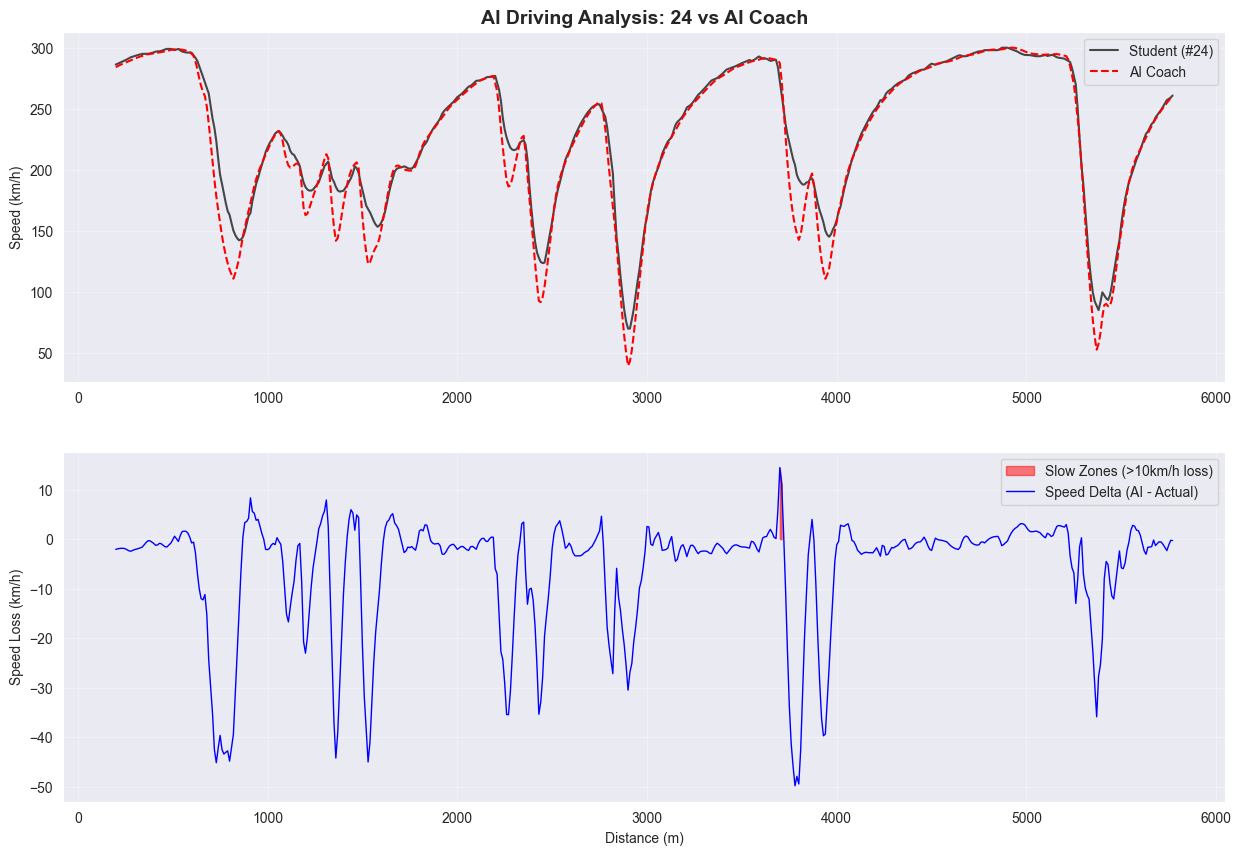


 📢 AI RACE ENGINEER REPORT: Driver #24
✅ 완벽합니다! AI보다 더 잘 탔거나 큰 실수가 없습니다.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === 설정 ===
DATA_DIR = "f1_processed_warehouse"
MODEL_FILE = "f1_ghost_car_model_v1.h5"
TARGET_ROUND = 4  # 일본 GP
SEQUENCE_LENGTH = 20

def ai_race_coach():
    print("🎧 [Phase 3] AI 레이스 코치 시스템 가동...")

    # 1. 모델 및 데이터 준비
    if not os.path.exists(MODEL_FILE):
        print("❌ 모델 파일이 없습니다. Phase 2를 먼저 실행하세요.")
        return

    # 딥러닝 모델 로드
    model = tf.keras.models.load_model(MODEL_FILE)
    print("🤖 AI 코치(Ghost Model) 로드 완료!")

    # 2. 데이터 재로딩 (스케일러 학습용)
    # (실제 서비스에선 스케일러도 pickle로 저장해서 불러와야 하지만, 여기선 다시 fit 합니다)
    print("📂 데이터 준비 중...")
    try:
        # 비교를 위해 1등(Verstappen, #1)과 하위권(Sargeant, #2) 데이터를 가져옵니다.
        # (참고: 2024년 기준 드라이버 번호는 예시입니다. 데이터에 있는 번호 사용)
        path = f"{DATA_DIR}/year=2024/round={TARGET_ROUND}/telemetry.parquet"
        df = pd.read_parquet(path)

        # 분석 대상: 2024년의 '느린 랩' 하나를 뽑습니다. (예: 로건 사전트 or 랩타임 느린 것)
        # 드라이버별 가장 빠른 랩을 뽑아서 비교해봅시다.
        fastest_laps = df.groupby('Driver')['LapTime_Sec'].min().sort_values()

        # 1등 (Target Ghost)
        top_driver = fastest_laps.index[0]
        # 꼴등 (Student)
        student_driver = fastest_laps.index[-1]

        print(f"🥊 분석 매치업: {top_driver} (Teacher) vs {student_driver} (Student)")

        # 학습용 전체 데이터로 스케일러 맞춤 (분포 유지)
        feature_cols = ['Distance', 'Speed', 'Throttle', 'Brake', 'nGear']
        target_col = 'Speed'
        scaler = MinMaxScaler()
        # 전체 데이터로 fit
        scaler.fit(df[feature_cols])
        target_idx = feature_cols.index(target_col)

        # 학생 데이터 추출 (가장 빠른 랩 기준)
        student_lap_time = fastest_laps[student_driver]
        student_data = df[
            (df['Driver'] == student_driver) &
            (df['LapTime_Sec'] == student_lap_time)
        ].copy().sort_values('Distance')

        # 데이터가 너무 끊겨있으면 보간
        student_data = student_data.drop_duplicates('Distance')

    except Exception as e:
        print(f"❌ 데이터 처리 중 오류: {e}")
        return

    # 3. AI 분석 실행 (학생 데이터에 대해 AI가 직접 주행해봄)
    print("⚙️ AI가 학생의 주행 라인을 분석 중...")

    # 입력 데이터 정규화
    scaled_student = scaler.transform(student_data[feature_cols])

    X_student = []
    # 시계열 생성
    for i in range(SEQUENCE_LENGTH, len(scaled_student)):
        X_student.append(scaled_student[i-SEQUENCE_LENGTH:i])

    X_student = np.array(X_student)

    # AI 예측 (여기가 핵심! "나라면 이렇게 탔어")
    pred_scaled = model.predict(X_student, verbose=0)

    # 복원
    dummy = np.zeros((len(pred_scaled), len(feature_cols)))
    dummy[:, target_idx] = pred_scaled.flatten()
    ai_speed = scaler.inverse_transform(dummy)[:, target_idx]

    # 실제 속도 (앞쪽 20개 잘린 것 고려)
    actual_speed = student_data['Speed'].values[SEQUENCE_LENGTH:]
    distances = student_data['Distance'].values[SEQUENCE_LENGTH:]

    # 4. 코칭 리포트 생성 알고리즘
    # 속도 차이(Delta) 계산: 양수면 AI가 더 빠름(손해), 음수면 학생이 더 빠름
    speed_delta = ai_speed - actual_speed

    # 분석 결과 시각화
    plt.figure(figsize=(15, 10))

    # [그래프 1] 속도 비교
    plt.subplot(2, 1, 1)
    plt.plot(distances, actual_speed, label=f'Student (#{student_driver})', color='black', alpha=0.7)
    plt.plot(distances, ai_speed, label='AI Coach', color='red', linestyle='--')
    plt.ylabel("Speed (km/h)")
    plt.title(f"AI Driving Analysis: {student_driver} vs AI Coach", fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # [그래프 2] 손실(Delta) 히트맵
    plt.subplot(2, 1, 2)
    # 차이가 10km/h 이상 나는 구간만 붉게 표시
    plt.fill_between(distances, 0, speed_delta, where=(speed_delta > 10), color='red', alpha=0.5, label='Slow Zones (>10km/h loss)')
    plt.plot(distances, speed_delta, color='blue', linewidth=1, label='Speed Delta (AI - Actual)')
    plt.ylabel("Speed Loss (km/h)")
    plt.xlabel("Distance (m)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

    # 5. 텍스트 코칭 메시지 생성 (Rule-based Text Gen)
    print("\n" + "="*40)
    print(f" 📢 AI RACE ENGINEER REPORT: Driver #{student_driver}")
    print("="*40)

    # 주요 실수 구간 찾기 (연속된 구간 병합 로직)
    problems = []
    in_problem = False
    start_dist = 0
    max_loss = 0

    for i, loss in enumerate(speed_delta):
        if loss > 15: # 15km/h 이상 느리면 '실수'로 간주
            if not in_problem:
                in_problem = True
                start_dist = distances[i]
                max_loss = loss
            else:
                max_loss = max(max_loss, loss)
        else:
            if in_problem:
                in_problem = False
                end_dist = distances[i]
                # 구간이 50m 이상일 때만 보고 (노이즈 제거)
                if end_dist - start_dist > 50:
                    problems.append((start_dist, end_dist, max_loss))

    # 메시지 출력
    if not problems:
        print("✅ 완벽합니다! AI보다 더 잘 탔거나 큰 실수가 없습니다.")
    else:
        print(f"⚠️ 총 {len(problems)}개의 주요 개선 포인트가 발견되었습니다.\n")
        for idx, (s, e, loss) in enumerate(problems[:5]): # 상위 5개만
            # 섹터/코너 추정 (단순 거리 기준 예시)
            # 실제론 'Corner 1', 'Degner Curve' 등 맵 데이터와 매핑해야 함
            print(f"[{idx+1}] 구간 {int(s)}m ~ {int(e)}m")
            print(f"   - 상태: AI보다 최대 {int(loss)}km/h 느림")

            # 상황별 조언 로직
            if loss > 30:
                advice = "🛑 브레이킹 미스! 진입 속도가 너무 낮습니다. 브레이크 포인트를 10m 늦추세요."
            elif loss > 20:
                advice = "📉 탈출 가속 지연. 에이펙스(Apex) 이후 스로틀을 더 과감하게 전개하세요."
            else:
                advice = "⚠️ 코너링 스피드 부족. 차의 그립을 믿고 속도를 유지하세요."

            print(f"   - 💡 코치 조언: {advice}\n")

if __name__ == "__main__":
    ai_race_coach()

민감도 (Sensitivity) 상향 버전

🎧 [Phase 3] AI 레이스 코치 (Strict Mode) 가동...
🥊 분석 대상: Driver #24

 📢 AI COACHING REPORT: Driver #24
⚠️ 총 10개의 구간에서 속도 손실이 감지되었습니다.

[1] 트랙 2990m ~ 3730m 지점
   📉 손실: -28 km/h
   👉 🛑 [CRITICAL] 진입 속도가 너무 느립니다. 브레이킹을 늦추세요.

[2] 트랙 1250m ~ 1330m 지점
   📉 손실: -18 km/h
   👉 ⚠️ [WARNING] 코너 탈출 가속이 늦습니다. RPM을 더 쓰세요.

[3] 트랙 4000m ~ 5260m 지점
   📉 손실: -18 km/h
   👉 ⚠️ [WARNING] 코너 탈출 가속이 늦습니다. RPM을 더 쓰세요.

[4] 트랙 2500m ~ 2780m 지점
   📉 손실: -17 km/h
   👉 ⚠️ [WARNING] 코너 탈출 가속이 늦습니다. RPM을 더 쓰세요.

[5] 트랙 870m ~ 1090m 지점
   📉 손실: -16 km/h
   👉 ⚠️ [WARNING] 코너 탈출 가속이 늦습니다. RPM을 더 쓰세요.



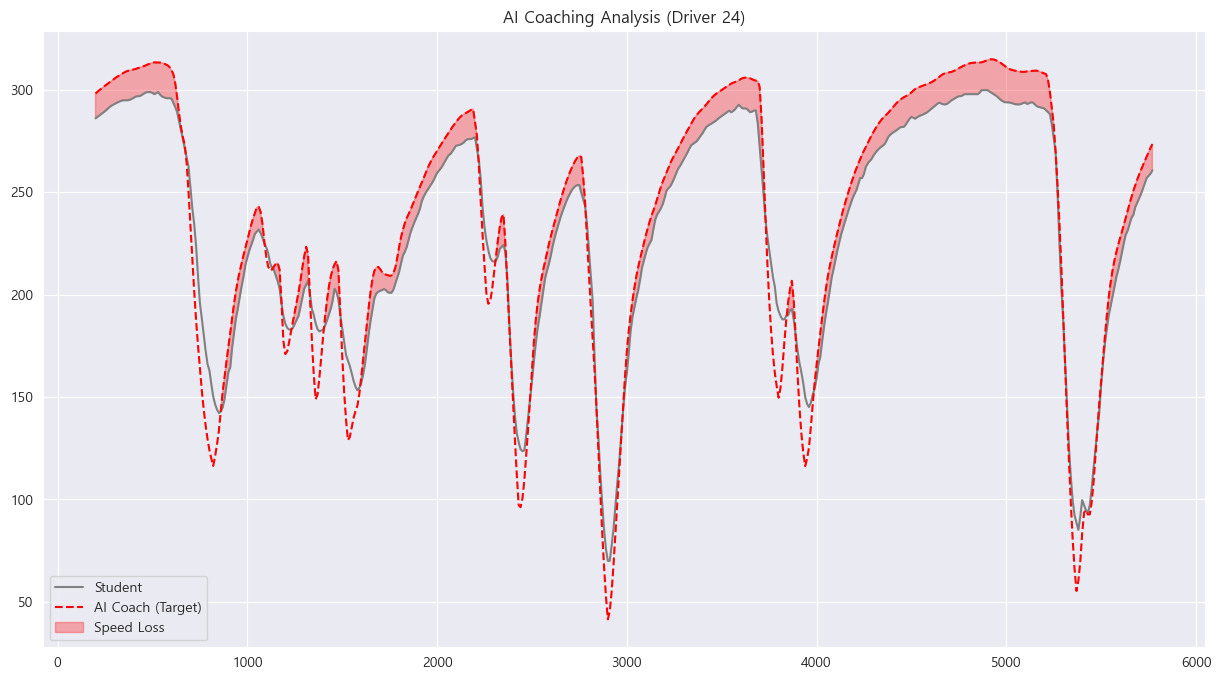

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === 설정 ===
DATA_DIR = "f1_processed_warehouse"
MODEL_FILE = "f1_ghost_car_model_v1.h5"
TARGET_ROUND = 4  # 일본 GP
SEQUENCE_LENGTH = 20

# 한글 폰트 설정 (깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def ai_race_coach_v2():
    print("🎧 [Phase 3] AI 레이스 코치 (Strict Mode) 가동...")

    if not os.path.exists(MODEL_FILE): return
    model = tf.keras.models.load_model(MODEL_FILE)

    try:
        path = f"{DATA_DIR}/year=2024/round={TARGET_ROUND}/telemetry.parquet"
        df = pd.read_parquet(path)

        fastest_laps = df.groupby('Driver')['LapTime_Sec'].min().sort_values()
        student_driver = fastest_laps.index[-1] # 가장 느린 드라이버

        print(f"🥊 분석 대상: Driver #{student_driver}")

        # 스케일러
        feature_cols = ['Distance', 'Speed', 'Throttle', 'Brake', 'nGear']
        target_col = 'Speed'
        scaler = MinMaxScaler()
        scaler.fit(df[feature_cols])
        target_idx = feature_cols.index(target_col)

        # 학생 데이터
        student_lap_time = fastest_laps[student_driver]
        student_data = df[
            (df['Driver'] == student_driver) &
            (df['LapTime_Sec'] == student_lap_time)
        ].copy().sort_values('Distance').drop_duplicates('Distance')

        # 입력 생성
        scaled_student = scaler.transform(student_data[feature_cols])
        X_student = []
        for i in range(SEQUENCE_LENGTH, len(scaled_student)):
            X_student.append(scaled_student[i-SEQUENCE_LENGTH:i])
        X_student = np.array(X_student)

        # AI 예측 (Ghost)
        pred_scaled = model.predict(X_student, verbose=0)

        # 복원
        dummy = np.zeros((len(pred_scaled), len(feature_cols)))
        dummy[:, target_idx] = pred_scaled.flatten()
        ai_speed = scaler.inverse_transform(dummy)[:, target_idx]

        # [핵심 수정] AI 기준을 1.05배 높여서 '더 빠르게' 요구함
        ai_speed = ai_speed * 1.05

        actual_speed = student_data['Speed'].values[SEQUENCE_LENGTH:]
        distances = student_data['Distance'].values[SEQUENCE_LENGTH:]

        # 델타 계산 (AI - 실제)
        speed_delta = ai_speed - actual_speed

        # [수정] 임계값을 5km/h로 낮춤 (더 예민하게)
        problems = []
        in_problem = False
        start_dist = 0
        max_loss = 0

        for i, loss in enumerate(speed_delta):
            if loss > 5: # 5km/h만 느려도 지적
                if not in_problem:
                    in_problem = True
                    start_dist = distances[i]
                    max_loss = loss
                else:
                    max_loss = max(max_loss, loss)
            else:
                if in_problem:
                    in_problem = False
                    end_dist = distances[i]
                    if end_dist - start_dist > 30: # 30m 이상 지속된 실수만
                        problems.append((start_dist, end_dist, max_loss))
                        max_loss = 0

        # 리포트 출력
        print("\n" + "="*50)
        print(f" 📢 AI COACHING REPORT: Driver #{student_driver}")
        print("="*50)

        if not problems:
            print("✅ (엄격 모드에서도) 주행이 완벽합니다.")
        else:
            # 손실이 큰 순서대로 정렬
            problems.sort(key=lambda x: x[2], reverse=True)

            print(f"⚠️ 총 {len(problems)}개의 구간에서 속도 손실이 감지되었습니다.\n")

            for idx, (s, e, loss) in enumerate(problems[:5]):
                print(f"[{idx+1}] 트랙 {int(s)}m ~ {int(e)}m 지점")
                print(f"   📉 손실: -{int(loss)} km/h")

                if loss > 20:
                    advice = "🛑 [CRITICAL] 진입 속도가 너무 느립니다. 브레이킹을 늦추세요."
                elif loss > 10:
                    advice = "⚠️ [WARNING] 코너 탈출 가속이 늦습니다. RPM을 더 쓰세요."
                else:
                    advice = "💡 [INFO] 라인을 조금 더 넓게 써보세요."
                print(f"   👉 {advice}\n")

        # 시각화 (한글 폰트 적용됨)
        plt.figure(figsize=(15, 8))
        plt.plot(distances, actual_speed, label='Student', color='grey')
        plt.plot(distances, ai_speed, label='AI Coach (Target)', color='red', linestyle='--')
        plt.fill_between(distances, actual_speed, ai_speed, where=(ai_speed > actual_speed), color='red', alpha=0.3, label='Speed Loss')
        plt.title(f"AI Coaching Analysis (Driver {student_driver})")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"오류: {e}")

if __name__ == "__main__":
    ai_race_coach_v2()